In [1]:
ENV["OMP_NUM_THREADS"] = 20
using PyCall, PyPlot
using Healpix
PyPlot.svg(true)
np = pyimport("numpy")
hp = pyimport("healpy")
Threads.nthreads()

20

## Step 1: Load in $B_{\ell}$

The $b_{\ell}^m$ are inverse noise-weighted beam multipoles.

In [2]:
blm_file = "/tigress/adriaand/actpol/20210316_quickpol/blm.fits"
# blm, mmax = hp.read_alm(blm_file, return_mmax=true);  # python version of call

lmax, mmax = 30000, 100
blm = Alm(lmax, mmax, readAlmFromFITS(blm_file, Complex{Float64}));

blm.alm ./= (blm.alm[almIndex(blm, 0, 0)] * sqrt.(4π ./ (2*0 .+ 1)) );

We plot them with a nice normalization factor.

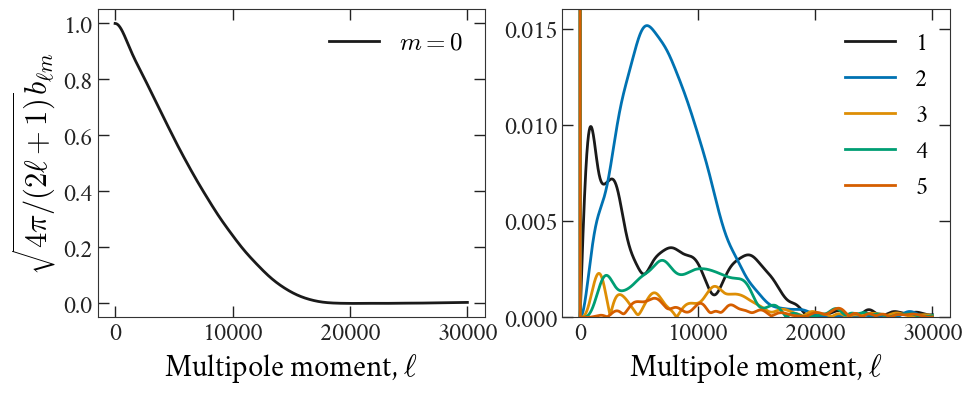

In [3]:
clf()
fig, axes = plt.subplots(1,2,figsize=(11,4))
ℓ = 0:lmax
factor = sqrt.(4π ./ (2ℓ .+ 1))
axes[1].plot(factor .* [abs(blm.alm[almIndex(blm, l, 0)]) for l in 0:lmax], "-", label=raw"$m=0$")

for m in 1:5
    axes[2].plot(factor .* [abs(blm.alm[almIndex(blm, l, m)]) for l in 0:lmax], "-", label="$m")
end
axes[2].set_ylim(0,0.016)
axes[1].set_ylabel(raw"$\sqrt{4\pi/(2\ell+1)} b_{\ell m}$")
axes[1].set_xlabel(raw"Multipole moment, $\ell$")
axes[2].set_xlabel(raw"Multipole moment, $\ell$")
axes[1].legend(); axes[2].legend();
gcf()

We obtain the $\omega$ from a map2alm of the xlink map.

In [4]:
enmap = pyimport("pixell.enmap")
curvedsky = pyimport("pixell.curvedsky")

xlinkname = "/tigress/adriaand/actpol/20210316_quickpol/s13_deep5_pa1_f150_nohwp_night_3pass_4way_coadd_xlink.fits" 
xlinkmap = pycall(enmap.read_map, PyObject, xlinkname)  # need to call it like this to prevent autoconvert
@time xlink_alm = curvedsky.map2alm(xlinkmap, lmax=30000)

 47.106134 seconds (787.65 k allocations: 10.100 GiB, 0.15% gc time)


3×450045001 Array{Complex{Float32},2}:
 1.41628f-5+0.0im  2.28704f-7+0.0im  …  4.84314f-11+3.40512f-11im
        0.0+0.0im         0.0+0.0im     4.29879f-12-6.07352f-12im
        0.0+0.0im         0.0+0.0im     -3.8811f-11+2.68674f-11im

## Conversion from T,E,B to 0,2,-2
$$a_{2, lm} = - a_{E, lm} - i a_{B,lm}$$
$$a_{-2, lm} = - a_{E, lm} + i a_{B,lm}$$

In [5]:
aT, aE, aB = xlink_alm[1,:], xlink_alm[2,:], xlink_alm[3,:]
ω₀, ω₊₂, ω₋₂  = Alm(lmax, lmax), Alm(lmax, lmax), Alm(lmax, lmax)

ω₀.alm .= aT
ω₊₂.alm .= -1  .* aE .- 1im .* aB
ω₋₂.alm .= -1  .* aE .+ 1im .* aB;

We limit ourselves to $\nu_1 = \nu_2 = u_1 = u_2 = 0$, but $s_1 = s_2 = 2$. The xlink can be used for  ${}_2\tilde{\omega}_{\ell m}$. In this case we only have one array, $j_1 = j_2$.

Now we define $\mathbf{Q}_{\ell^{\prime\prime},\ell}$ such that 
$$\tilde{C}^{\nu_1,\nu_2}_{\ell^{\prime\prime}} = \sum_{\ell} \mathbf{Q}_{\ell^{\prime\prime},\ell} C_{\ell}^{u_1 u_2}$$
as specified in eq 38 of Hivon+17.

In [6]:
using BenchmarkTools
using BandedMatrices
using AngularPowerSpectra
@btime AngularPowerSpectra.kᵤ(0)

┌ Info: Precompiling AngularPowerSpectra [87acb811-fa58-4e83-857d-605afdc1041b]
└ @ Base loading.jl:1278
┌ Warning: No working GUI backend found for matplotlib
└ @ PyPlot ~/.julia/packages/PyPlot/XHEG0/src/init.jl:165


  0.017 ns (0 allocations: 0 bytes)


1.0

In [7]:
ω̃ = Dict(0 => ω₀, -2 => ω₋₂, 2 => ω₊₂)
b̂ = Dict(
    0 => SpectralVector([abs(blm.alm[almIndex(blm, l, 0)]) for l in 0:lmax]),
    1 => SpectralVector([abs(blm.alm[almIndex(blm, l, 1)]) for l in 0:lmax]),
    2 => SpectralVector([abs(blm.alm[almIndex(blm, l, 2)]) for l in 0:lmax]))

band = 100
# 𝐐 = SpectralArray(BandedMatrix(Zeros(10,10), (band,band)))
# AngularPowerSpectra.quickpol!(Float64, 0, 0, [0], [0], [2], [2], ω̃, ω̃, b̂, b̂, lmax)

100

In [8]:
# AngularPowerSpectra.quickpol!(𝐐, 0, 0, [0], [0], [2], [2], ω̃, ω̃, b̂, b̂)

In [9]:
using AngularPowerSpectra
using LinearAlgebra

In [24]:
𝚵 = SpectralArray(BandedMatrix(Zeros(300,300), (band,band)))
# 𝚵 = SpectralArray(zeros(100,100))
#                                      ν₁,ν₂,s₁,s₂,  ω₁,   ω₂
@time AngularPowerSpectra.quickpolΞ!(𝚵, 0, 0, 2, 2, ω̃[2], ω̃[2]);

  0.308467 seconds (7.67 k allocations: 651.234 KiB)


In [26]:
# for ℓ = 0:999
#     𝚵[:,ℓ] .*= 2ℓ + 1
# end

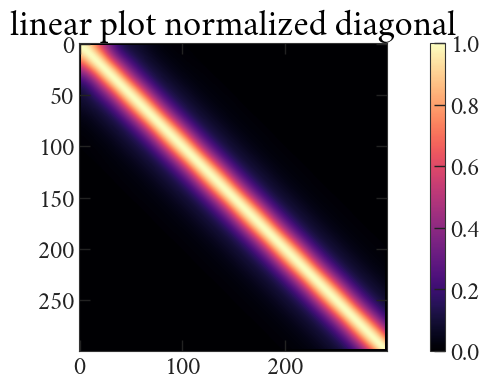

In [36]:
clf()
title("linear plot normalized diagonal")
xicopy = deepcopy(𝚵.parent)

for ℓ = 3:(size(𝚵,1)-2)
    xid = xicopy[ℓ, ℓ]
    xicopy[ℓ,:] ./= √xid
    xicopy[:,ℓ] ./= √xid
end

imshow( xicopy )
colorbar()
gcf()

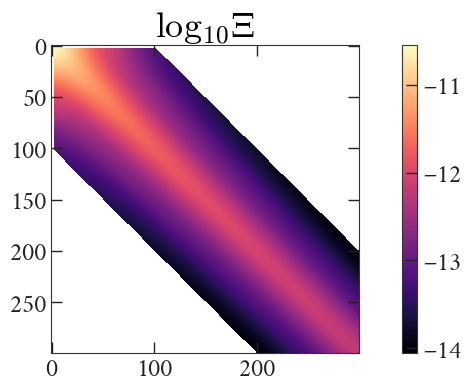

In [31]:
clf()
title(raw"$\log_{10}\Xi$")
imshow( log10.(𝚵) )
colorbar()
gcf()

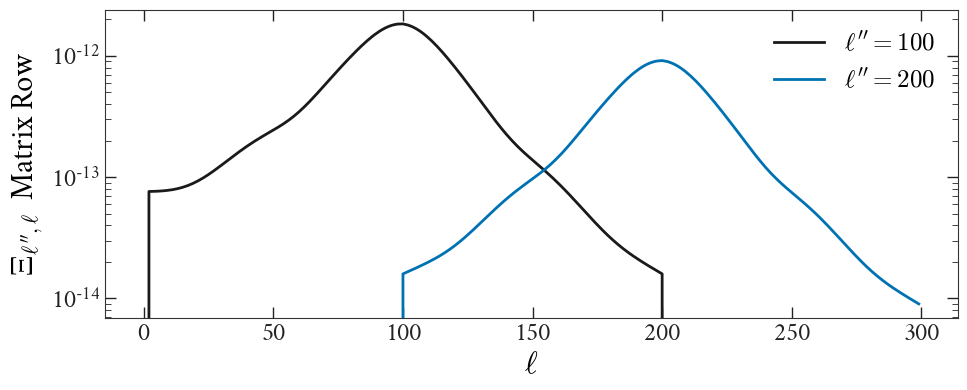

In [34]:
clf()
plot(𝚵[100,:], "-", label=raw"$\ell^{\prime\prime} = 100$")
plot(𝚵[200,:], "-", label=raw"$\ell^{\prime\prime} = 200$")
# plot(𝚵[700,:], "-", label=raw"$\ell^{\prime\prime} = 700$")
xlabel(raw"$\ell$")
ylabel(raw"$\mathbf{\Xi}_{\ell'',\ell}$  Matrix Row")
yscale("log")
legend()
gcf()

In [17]:
# for ℓ = 0:10
#     @show ℓ max(2,BandedMatrices.rowstart(𝚵.parent,ℓ+1)-1)
# end

In [18]:
# 𝚵